In [1]:
import tensorflow as tf
import numpy as np
import csv
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from matplotlib import pyplot as plt

In [2]:
dataframe = pd.read_csv('./Training_trial.csv')


In [3]:
dataframe.shape

(6400, 33)

In [4]:
dataframe.head()

,fs8_1,sfs8_1,fs8_2,sfs8_2,fs8_3,sfs8_3,fs8_4,sfs8_4,fs8_5,sfs8_5,...,sfs8_12,fs8_13,sfs8_13,fs8_14,sfs8_14,fs8_15,sfs8_15,fs8_16,sfs8_16,target
0,0.028757,0.006291,0.033717,0.00617,0.038449,0.00606,0.042823,0.005988,0.046748,0.005955,...,0.005767,0.061399,0.005687,0.061347,0.005598,0.061107,0.005503,0.060709,0.005402,0.0
1,0.029932,0.006291,0.035011,0.00617,0.039847,0.00606,0.044308,0.005988,0.048306,0.005955,...,0.005767,0.063049,0.005687,0.062972,0.005598,0.062703,0.005503,0.062277,0.005402,0.0
2,0.031131,0.006291,0.036330,0.00617,0.041271,0.00606,0.045821,0.005988,0.049891,0.005955,...,0.005767,0.064722,0.005687,0.064619,0.005598,0.064322,0.005503,0.063865,0.005402,0.0
3,0.032353,0.006291,0.037674,0.00617,0.042721,0.00606,0.047360,0.005988,0.051502,0.005955,...,0.005767,0.066415,0.005687,0.066285,0.005598,0.065959,0.005503,0.065471,0.005402,0.0
4,0.033596,0.006291,0.039039,0.00617,0.044193,0.00606,0.048923,0.005988,0.053138,0.005955,...,0.005767,0.068126,0.005687,0.067969,0.005598,0.067613,0.005503,0.067094,0.005402,0.0


In [5]:
dataframe['target'] = dataframe['target'].replace(3, 2)
target_2_rows = dataframe[dataframe['target'] == 2]
sample_size = len(target_2_rows) // 2
target_2_sample = target_2_rows.sample(n=sample_size, random_state=42)
remaining_rows = dataframe[dataframe['target'] != 2]
dataframe = pd.concat([remaining_rows, target_2_sample])

In [6]:
dataframe = dataframe.sample(frac=1).reset_index(drop=True)
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

In [7]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [8]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    normalizer = Normalization()

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    normalizer.adapt(feature_ds)

    encoded_feature = normalizer(feature)
    return encoded_feature

In [9]:
int((len(dataframe.columns)))

33

In [10]:
## Create lists to store inputs and encoded features
all_inputs = []
all_features_encoded = []

# Create inputs and encode numerical features
for i in range(1, int((len(dataframe.columns)+1)/2)):
    fs_input = keras.Input(shape=(1,), name=f"fs8_{i}")
    sfs_input = keras.Input(shape=(1,), name=f"sfs8_{i}")

    fs_encoded = encode_numerical_feature(fs_input, f"fs8_{i}", train_ds)
    sfs_encoded = encode_numerical_feature(sfs_input, f"sfs8_{i}", train_ds)

    all_inputs.extend([fs_input, sfs_input])
    all_features_encoded.extend([fs_encoded, sfs_encoded])

# Concatenate all encoded features
all_features = layers.concatenate(all_features_encoded)

In [11]:
from keras.optimizers import Nadam

x = layers.Dense(32, activation="relu", name="dense_1")(all_features)
x = layers.Dropout(0.1)(x)
x = layers.Dense(16, activation='relu', name="dense_3")(x) 
outputs = layers.Dense(3, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=all_inputs, outputs=outputs)

model.compile(optimizer='nadam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

early_stopping = callbacks.EarlyStopping(
   monitor='val_loss',
   patience=100, #after how many epochs the accuracy, loss don't change
   restore_best_weights=True
)

history = model.fit(
    train_ds,
    epochs=2000, 
    validation_data=val_ds, callbacks=early_stopping
)

Epoch 1/2000
120/120 [==============================] - 2s 5ms/step - loss: 0.9955 - accuracy: 0.4453 - val_loss: 0.9698 - val_accuracy: 0.4688
Epoch 2/2000
120/120 [==============================] - 0s 3ms/step - loss: 0.9453 - accuracy: 0.5081 - val_loss: 0.9260 - val_accuracy: 0.5146
Epoch 3/2000
120/120 [==============================] - 0s 3ms/step - loss: 0.9049 - accuracy: 0.5562 - val_loss: 0.8844 - val_accuracy: 0.5708
Epoch 4/2000
120/120 [==============================] - 0s 2ms/step - loss: 0.8719 - accuracy: 0.5760 - val_loss: 0.8452 - val_accuracy: 0.6135
Epoch 5/2000
120/120 [==============================] - 0s 2ms/step - loss: 0.8435 - accuracy: 0.5922 - val_loss: 0.8177 - val_accuracy: 0.6104
Epoch 6/2000
120/120 [==============================] - 0s 3ms/step - loss: 0.8220 - accuracy: 0.6000 - val_loss: 0.7998 - val_accuracy: 0.6135
Epoch 7/2000
120/120 [==============================] - 0s 3ms/step - loss: 0.8017 - accuracy: 0.6182 - val_loss: 0.7807 - val_accuracy:

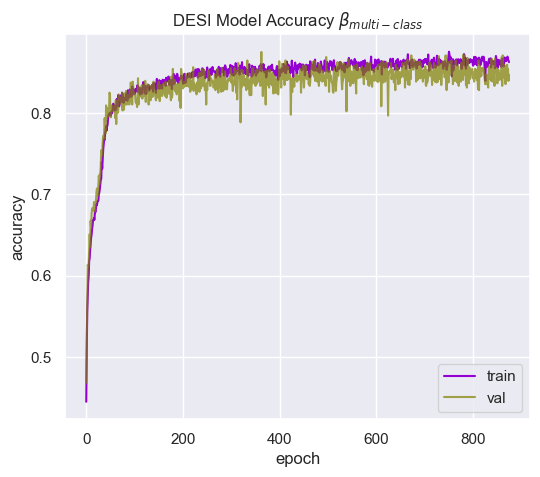

In [12]:
import seaborn as sns
sns.set_theme()
fig = plt.figure(figsize=(6,5))
plt.plot(history.history['accuracy'], color='darkviolet')
plt.plot(history.history['val_accuracy'],alpha=0.7, color='olive')
plt.title(r'DESI Model Accuracy $\beta_{multi-class}$')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
#plt.ylim([0.3,0.75])
plt.show()
fig.savefig('./plots/CDE_accuracy_multi_beta.pdf', bbox_inches='tight')

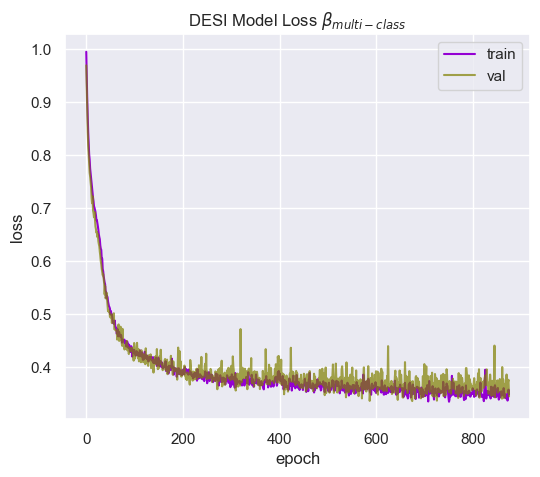

In [13]:
fig = plt.figure(figsize=(6,5))
plt.plot(history.history['loss'], color='darkviolet')
plt.plot(history.history['val_loss'],alpha=0.7, color='olive')
plt.title(r'DESI Model Loss $\beta_{multi-class}$')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.ylim([0.6,1])
plt.show()
fig.savefig('./plots/CDE_loss_multi_beta.pdf', bbox_inches='tight')

In [14]:
def norm(p):
  if 0<p<0.5:
    rr=1-p
  else:
    rr=p
  return rr

In [16]:
dict_reader = pd.read_csv('./Test_trial.csv')

dict_reader['target'] = dict_reader['target'].replace(3, 2)
target_2_rows = dict_reader[dict_reader['target'] == 2]
sample_size = len(target_2_rows) // 2
target_2_sample = target_2_rows.sample(n=sample_size, random_state=42)
remaining_rows = dict_reader[dict_reader['target'] != 2]
dict_reader = pd.concat([remaining_rows, target_2_sample])

In [17]:
test_models = dict_reader.to_dict(orient='records')

In [18]:
true_model=[]
pred_model=[]
predictions=[]
#prob_pred=[]

for i in range(len(test_models)):
  sample = test_models[i]
  true_model.append(round(test_models[i]['target']))
  sample.pop('target', None) #gets rid off target
  input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()} 
  predictions.append(model.predict(input_dict))
  index_max = np.argmax(model.predict(input_dict))
  pred_model.append(index_max)
  #prob_pred.append(round(100*norm(predictions[0][0]),3))

1/1 [==============================] - 0s 79ms/step


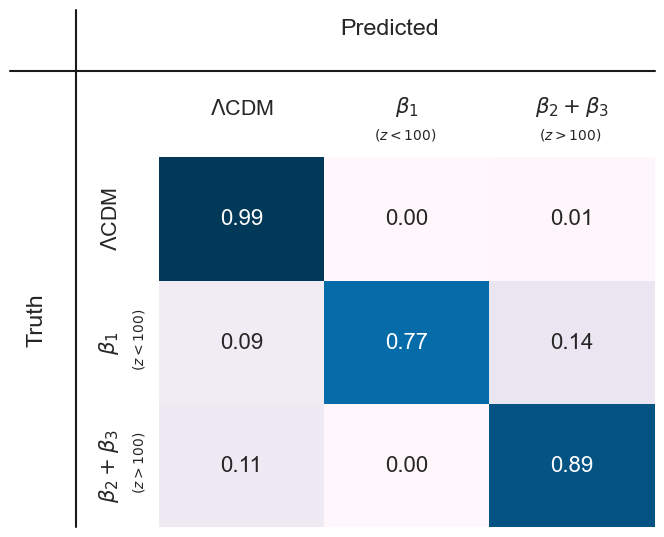

In [23]:
#Confusion matrix
from sklearn import metrics

cm = metrics.confusion_matrix(true_model, pred_model)

#Create normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = sns.heatmap(cm_normalized, cmap='PuBu',annot=True, annot_kws={"size": 16},cbar=False, fmt=".2f",
            xticklabels=[r'$\Lambda$CDM', r'$\beta_1$', r'$\beta_2+\beta_3$'],
            yticklabels=[r'$\Lambda$CDM', r'$\beta_1$', r'$\beta_2+\beta_3$'])#, 
            # xticklabels=['$\Lambda$CDM', 'HS'],
            # yticklabels=['$\Lambda$CDM', 'HS'])

# Customize the plot
ax.xaxis.tick_top()
ax.xaxis.set_ticks_position('none')
ax.text(1.1, -1., 'Predicted')
ax.text(-0.8, 1.5, 'Truth', rotation='vertical')
ax.text(1.3, -0.15, '$(z<100)$', fontsize=10)
ax.text(2.3, -0.15, '$(z>100)$', fontsize=10)
for tick in ax.get_xticklabels():
    tick.set_verticalalignment('bottom')
    tick.set_y(tick.get_position()[1] + 0.07)

plt.yticks(rotation=90)
for tick in ax.get_yticklabels():
    tick.set_horizontalalignment('right')
    tick.set_x(tick.get_position()[0] - 0.05)
ax.text(-0.17, 1.7, '$(z<100)$', rotation='vertical', fontsize=10)
ax.text(-0.17, 2.7, '$(z>100)$', rotation='vertical', fontsize=10)

ax.axvline(-0.5, ymax=1.4, clip_on=False, color='k')
ax.axhline(-0.7, xmin=-0.3, clip_on=False, color='k')